# Microgrid optimization with an algebraic approach using JuMP

**Microgrid sizing optimization** notebook example, derived from similar [Microgrids.jl’s example](https://github.com/Microgrids-X/Microgrids.jl/blob/main/examples/Microgrid_sizing_optimization.ipynb).
However, instead of doing a sizing optimization using a Microgrid simulator embedded in blackbox iterative optimization loop,
here we use an **algebraic description** of the problem (using the [JuMP](https://jump.dev/) package) and we run an "all-in-one" optimization of both the sizing and the energy flows at each instant.

Caveat: this yields an anticipative energy management.

PH, oct 2023, sept 2024

In [1]:
using Microgrids

# Optimization
using JuMP
using HiGHS # Linear Programming solver

# Display
using Printf # pretty print results
using PyPlot

Check version of Microgrids.jl (v0.11.0 needed)

In [2]:
import Pkg
Pkg.status("Microgrids")

Status `~/.julia/environments/v1.10/Project.toml`
  [bd581358] Microgrids v0.11.0


## Load Microgrid project data

Loading parameters and time series for a Microgrid project with *wind* and *solar* sources, plus a *battery* and a *dispatchable generator*. 
Values gathered from the Microgrid_Wind-Solar.ipynb example notebook.

In [3]:
include("./example/Microgrid_Wind-Solar_data.jl");

Base Wind-Solar Microgrid project definition functions...


In [4]:
const tseries = load_microgrid_tseries();

loading times series from data/Ouessant_data_2016.csv...


In [5]:
"""Create a Microgrid project description of size `x`

x should be [
    power_rated_gen,
    energy_rated_sto,
    power_rated_pv,
    power_rated_wind
] (in kW or kWh)

Apart from the sizing, the project is based on parameters
defined by the function `create_mg_base` which
defaults to the globally defined `create_mg_base`.
This allows modifying some project parameters.
"""
function create_microgrid(x; create_mg_base=create_mg_base)
    mg = create_mg_base()

    # force ConsistentSalvage, necessary for making Microgrids.jl’s simulate results
    # comparable with the JuMP-based LP model which uses annalized costs
    mg.project.salvage_type = ConsistentSalvage

    # Set the size
    mg.generator.power_rated = x[1] # power_rated_gen
    mg.storage.energy_rated = x[2] # energy_rated_sto
    mg.nondispatchables[1].power_rated = x[3] # power_rated_pv
    mg.nondispatchables[2].power_rated = x[4] # power_rated_wind

    return mg
end

create_microgrid

Create a base Microgrid project description, which assembles all the date, with a dummy sizing [1,1,1,1] kW(h), so as to be able to call `production` function for non dispatchable sources.
- changes to the default set of parameters from `./example/Microgrid_Wind-Solar_data.jl` are implemented with the `create_mg_modified` function

In [6]:
"""Modify Microgrid project by *multiplying* base price values:
- `sto`: `mg.storage.investment_price` 
- `gen`: `mg.generator.investment_price` 
- `fuel`: `mg.generator.fuel_price`
"""
function modify_mg_prices(;sto=1.0, gen=1.0, fuel=1.0)
    println("mg prices modifications: sto*=$sto, gen*=$gen, fuel*=$fuel")
    function modify_mg(mg)
        mg.storage.investment_price *= sto
        mg.generator.investment_price *= gen
        mg.generator.fuel_price *= fuel
        return mg # return mg to allow chaining
    end
    return modify_mg
end

create_mg_modified = modify_mg_prices(sto=0.25) ∘ create_mg_base # composition create_mg_base -> modify_mg

mg = create_microgrid([1., 1, 1, 1], create_mg_base=create_mg_modified)
dt = mg.project.timestep
mg

mg prices modifications: sto*=0.25, gen*=1.0, fuel*=1.0


Microgrid{Float64}(Project(25, 0.05, 1.0, "€", ConsistentSalvage), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableGenerator{Float64}(1.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(1.0, 87.5, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(1.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0), WindPower{Float64}(1.0, [0.03184904690521816, 0.1104932647748532, 0.24596484619739856, 0.44422012231738006, 0.6554128208926687, 0.8470913237698507, 0.9579413031865969, 0.9735278942424532, 0.9837469734016646, 0.9903667231838823  …  0.011233045262998936, 0.018460507449516883, 0.023644167600765466, 0.02969747711584798, 0.036359043012900244, 0.03713796382151399, 0.0375303795

### Sizing bounds for each component

In [7]:
Pload_max = maximum(tseries.Pload) # kW
@printf("Max load power: %.1f kW", Pload_max)
power_rated_gen_max = 1.2 * Pload_max
energy_rated_sto_max = 10.0 * Pload_max
power_rated_pv_max = 10.0 * Pload_max
power_rated_wind_max = 5.0 * Pload_max;

Max load power: 1707.0 kW

### Time series reduction

Crude approach for model demonstration purpose only: simply decimating the sequence of days.    
For better approaches (e.g. daily profiles clustering), see Hoffmann *et al.*, “The Pareto-optimal temporal aggregation of energy system models,” Applied Energy, 2022, doi: [10.1016/j.apenergy.2022.119029.](https://doi.org/10.1016/j.apenergy.2022.119029) 

In [8]:
"""reduce the year time series `x` to `ndays` ≤ 365
sr=24: data sampling rate / day. 24 means hourly time step.

The method is *basic*:
it samples `ndays` days evenly spaced by (365 ÷ `ndays`) days

with ndays=365, returns the orinal series
"""
function ts_reduction(x, ndays, sr=24)
    out = zeros(ndays*sr)
    @assert ndays<=365
    Δdays = 365 ÷ ndays
    for i in 1:ndays
        offset_in = (i-1)*Δdays*sr
        offset_out = (i-1)*sr
        out[offset_out+1:offset_out+sr] = x[offset_in+1:offset_in+sr]
    end
    return out
end

ts_reduction

### Select amount of data reduction for sizing:

In [9]:
ndays = 365 # 1 to 365
K = ndays*24 # h

ts_reduction_ndays(x) = ts_reduction(x, ndays)

println("working with $ndays days, that is $K timesteps")

working with 365 days, that is 8760 timesteps


In [10]:
Pload = mg.load |> ts_reduction_ndays
Eload_desired = sum(Pload)*dt*365/ndays # kWh, desired yearly load energy, compensating for data reduction

6.774979e6

Compute capacity factor time series, i.e. normalized potential production, for wind and solar:

In [11]:
# (works because the rated power in mg are set to 1 kW)
cf_pv   = production(mg.nondispatchables[1]) |> ts_reduction_ndays
cf_wind = production(mg.nondispatchables[2]) |> ts_reduction_ndays;

### Display time series

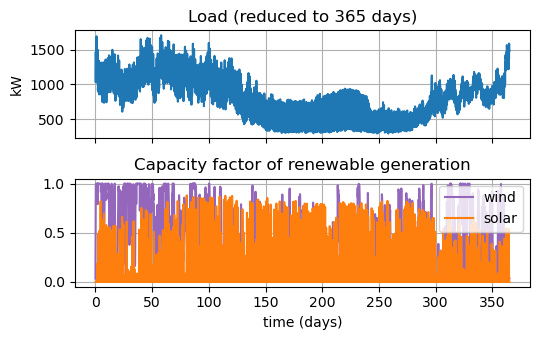

In [12]:
td = collect((0:K-1)/24) # time in days

fig, (ax1,ax2) = subplots(2,1, figsize=(5.5,3.5), sharex=true)

ax1.plot(td, Pload)
ax1.grid()
ax1.set(
    title="Load (reduced to $ndays days)",
    ylabel="kW"
)

ax2.plot(td, cf_wind, label="wind", color="tab:purple")
ax2.plot(td, cf_pv, label="solar", color="tab:orange")
ax2.grid()
ax2.legend(loc="upper right")
ax2.set(
    title="Capacity factor of renewable generation",
    xlabel="time (days)"
)

fig.tight_layout()

## JuMP optimization model

### Model options

Load shedding (unserved load) bound, as a fraction of cumulated desired load energy:

In [13]:
shed_max = 0.0 # in [0,1]

0.0

Choose between fixed lifetimes (gen and storage) vs usage-dependant:

In [14]:
fixed_lifetimes = false

false

assumed generator operation hours (used if `fixed_lifetimes = false`)

In [15]:
gen_hours_assum = 3000. # in 0 – 8760 h/y

3000.0

else, use a relaxation gain to try to compensate the underestimation of e.g. the generator operating hours due to linearization. Default is 1.0. Use higher gain for stronger generator usage penalty.

In [16]:
relax_gain = 1.0 # ≥ 1

1.0

### Init JuMP model

Create JuMP model, with an LP optimizer (HiGHS, Clp, GLPK...)

In [17]:
optimizer = HiGHS.Optimizer
model = Model(optimizer)
set_silent(model)

### Sizing variables

Rating of 4 components (in kW or kWh):

In [19]:
@variable(model, 0 <= power_rated_gen <= power_rated_gen_max)
@variable(model, 0 <= energy_rated_sto <= energy_rated_sto_max)
@variable(model, 0 <= power_rated_pv <= power_rated_pv_max)
@variable(model, 0 <= power_rated_wind <= power_rated_wind_max)

power_rated_wind

### Power flows for each component

Non dispatchable sources (renewables)

In [20]:
@variable(model, pv_potential[1:K])
@constraint(model, pv_potential .== power_rated_pv*cf_pv)
@variable(model, wind_potential[1:K])
@constraint(model, wind_potential .== power_rated_wind*cf_wind)
renew_potential = pv_potential + wind_potential
renew_potential[1]

pv_potential[1] + wind_potential[1]

Desired net load (before spillage of excess renewables and load shedding)

In [21]:
@variable(model, Pnl[1:K])
@constraint(model, Pnl .== Pload .- renew_potential);

Renewables spillage and load shedding

In [22]:
@variable(model, Pspill[1:K] >= 0)
@variable(model, Pshed[1:K] >= 0);

Dispatchable generator

In [23]:
@variable(model, Pgen[1:K] >= 0)
@constraint(model, Pgen .<= power_rated_gen);

### Energy storage

In [24]:
# Charge and discharge power (net of losses)
@variable(model, Psto_cha[1:K] >= 0)
@variable(model, Psto_dis[1:K] >= 0)
# Energy level and its bounds
@variable(model, Esto[1:K+1])
@constraint(model, Esto .<= energy_rated_sto) # SoCmax = 1 implicitly
@constraint(model, Esto .>= mg.storage.SoC_min*energy_rated_sto) # often 0
# Power constraints
@constraint(model, Psto_cha .<= mg.storage.charge_rate    * energy_rated_sto)
@constraint(model, Psto_dis .<= mg.storage.discharge_rate * energy_rated_sto)
# variant that embeds the two preceding ones, using that fact that Psto_cha(k) * Psto_dis(k) = 0
@constraint(model, Psto_cha/mg.storage.charge_rate + Psto_dis/mg.storage.discharge_rate  .<=  energy_rated_sto)[1]

-energy_rated_sto + Psto_cha[1] + Psto_dis[1] ≤ 0

Evolution of the State of Energy, with piecewise linear in P loss term (aka constant efficiency model)

In [25]:
a = mg.storage.loss_factor
@constraint(model,
    stodyn[k=1:K],
    Esto[k+1] == Esto[k] + (Psto_cha[k] - Psto_dis[k] - a*(Psto_cha[k]+Psto_dis[k]))*dt
    )
stodyn[1]

stodyn[1] : -0.95 Psto_cha[1] + 1.05 Psto_dis[1] - Esto[1] + Esto[2] = 0

Storage cyclicity

In [26]:
@constraint(model, Esto[K+1] == Esto[1])

-Esto[1] + Esto[8761] = 0

Optional: force initial SoC

In [27]:
mg.storage.SoC_ini # ...
#@constraint(model, Esto[1] == mg.storage.SoC_ini * energy_rated_sto)

0.0

### Power balance

at each of the `K` instants, generation should meet the load (±shedding and spillage):

In [28]:
@constraint(model, balance,
    Pgen + (Psto_dis - Psto_cha) - Pspill .== Pnl - Pshed)
balance[1]

balance : -Pnl[1] - Pspill[1] + Pshed[1] + Pgen[1] - Psto_cha[1] + Psto_dis[1] = 0

Shedding (unserved load) limit:
- either **zero shedding allowed**
- or a limit on the cumulated shedded energy

In [29]:
if shed_max == 0.0
    println("zero load shedding allowed")
    fix.(Pshed, 0.0; force=true)
else
    println("load shedding allowed: $shed_max")
    Eshed = sum(Pshed)*dt * 365/ndays
    @constraint(model, Eshed <= Eload_desired*shed_max)
end;

zero load shedding allowed


### Costs

we model annualized cost, to account for the different lifetime of each component

#### CRF helpers

In [30]:
"""capital recovery factor for discount rate `i` and duration `T`
CRF is such that Cann = NPC*CRF
"""
function CRF(i,T)
    if i != 0.0
        a = (1+i)^T
        return i*a/(a-1)
    else
        return 1/T
    end
end
CRF(0, 20), CRF(0.01, 20), CRF(0.05, 20), CRF(0.10, 20), CRF(0.20, 20)

(0.05, 0.055415314890551334, 0.08024258719069129, 0.11745962477254576, 0.20535653069304277)

In [31]:
discount_rate = mg.project.discount_rate

0.05

In [32]:
CRFproj(T) = CRF(discount_rate, T) 
CRFproj(20.)

0.08024258719069129

#### Annualized size linearization helpers

For the battery and the generator, to model the effect of **usage-dependent lifetime** (option `fixed_lifetimes = false`) on the annualized cost, we define the notion of “annualized size” function of size $x$ and usage $u$:

$$x_{ann}(x,u) = x.CRF(T(x, u))$$

with lifetime varying with size and usage as $T=x/u$. Then the annualized cost is simply $price \times x_{ann}$.

In a draft manuscript (*insert link when online*), we proove the joint convexity of $x_{ann}(x,u)$ and thus we use the piecewise linear approximation.

Alternatively, with a fixed lifetime assumption, then this annualized size is simply a fixed fraction of the actual size:

$$x_{ann} = x.CRF(T)$$


In [33]:
"""intercept and slope of tangent to function g:z → 1/(1-e^(-1/z))  at point `z0`

Usage: with gi, g1 = g_asym(z0),
then g(z) ~ gi + g1*z around z0
gi: intercept at z=0
g1: slope
"""
function g_tan(z0)
    z=z0
    emiz = exp(-1/z)
    g = 1/(1-emiz) # g(z)
    g1 = emiz/(z^2*(1-emiz)^2) # g'(z)
    ginter = g - g1*z
    return ginter, g1
end
g_tan(1e-3), g_tan(1/2), g_tan(1e3)

((1.0, 0.0), (0.7944868122665105, 0.7240616609663105), (0.500166666631003, 0.9999999166667313))

Choose where to place the tangents on $g(z)$. Recommended values:
- z_tan = [0.5]: 5% CRF underestimation error (used in Grenoble 2024 workshop slides)
- z_tan = [0.28, 0.5, 1.0]: 1.6% error
- z_tan = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0]: 0.23% error

In [34]:
z_tan = [0.5]
#z_tan = [0.28, 0.5, 1.0]
#z_tan = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0]

1-element Vector{Float64}:
 0.5

In [35]:
# stacked tangents: (ginter, g1) for each z0 in z_tan, including z=0 and +infty
[
    (1.0, 0.) # z0 = 0
    [(g_tan(z0)[1], g_tan(z0)[2]) for z0 in z_tan]
    (0.5, 1.0) # z0 -> +infty
]

3-element Vector{Tuple{Float64, Float64}}:
 (1.0, 0.0)
 (0.7944868122665105, 0.7240616609663105)
 (0.5, 1.0)

In [36]:
"""Piecewise linear approximation of “annualized size” function of size and usage

Parameters:
- Xann, X, U: JuMP variables or expressions
- discount_rate: Real number in [0,1] (negative discount not implemented)
- z_tan: list of z0 values where to use tangents of g(z).

Recommended values:
- z_tan = [0.5]: 5% CRF underestimation error
- z_tan = [0.28, 0.5, 1.0]: 1.6% error
- z_tan = [0.20, 0.28, 0.37, 0.50, 0.68, 1.0, 1.7, 4.0]: 0.23% error

Tangents at z=0 and z->+infty are also added, so no need to add these.

Returns the vector of constraints
"""
function cons_Xann_usage!(model, Xann, X, U, discount_rate, z_tan=[0.28, 0.5, 1.0])
    r = discount_rate/log(1+discount_rate)
    # stacked tangents: (ginter, g1) for each z0 in z_tan, including z=0 and +infty
    tan_params = [
        (1.0, 0.) # z0 = 0, yields Xann >= X*discount_rate
        [(g_tan(z0)[1], g_tan(z0)[2]) for z0 in z_tan]
        (0.5, 1.0) # z0 -> +inftyn yields Xann >= X*discount_rate*0.5 + U*r
    ]
    ntan = length(tan_params)
    cvec = @constraint(model, [k=1:ntan],
        Xann >= X*discount_rate*tan_params[k][1]
              + U*r*tan_params[k][2]
    )
    cname = "c_" * name(Xann) *"_"* name(X) *"_"* name(U)
    set_name.(cvec, [cname * "[$k]" for k=1:ntan])
    return cvec
end

cons_Xann_usage!

test `cons_Xann_usage!` helper

In [37]:
mtest = Model()
@variable(mtest, Xann)
@variable(mtest, X)
@variable(mtest, U)
cons_Xann_usage!(mtest, Xann, X, U, 0.05, z_tan)

3-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.GreaterThan{Float64}}, ScalarShape}}:
 c_Xann_X_U[1] : Xann - 0.05 X ≥ 0
 c_Xann_X_U[2] : Xann - 0.039724340613325526 X - 0.7420160121329831 U ≥ 0
 c_Xann_X_U[3] : Xann - 0.025 X - 1.0247967157143927 U ≥ 0

#### Generator

assumptions:
- constant efficiency, i.e. fuel curve intercept = 0
- (optionnally) fixed number of operating hours per year, to linearize both the O&M and investment&replacement (with fixed  lifetime)

Generator yearly energy (compensating for the optional data reduction when `ndays` ≠  365) 

In [38]:
Egen = sum(Pgen)*dt * 365/ndays;

We define its annualized size, which can depend on a usage-dependant lifetime $T$: $x_{ann} = x.CRF(T(x, u))$. Otherwise, its a fixed fraction of the size:

In [39]:
mg.generator.lifetime_hours # h

15000.0

In [40]:
if fixed_lifetimes
    print("Fixed generator lifetime hypothesis: ")
    gen_lifetime = mg.generator.lifetime_hours / gen_hours_assum # years
    println("$gen_lifetime y, assuming $gen_hours_assum  h/y of usage")
    Pgen_rated_ann = power_rated_gen * CRFproj(gen_lifetime)
end

In [41]:
if ~fixed_lifetimes
    println("Usage-dependent generator lifetime model (relax_gain=", relax_gain,")")
    @variable(model, Pgen_rated_ann >= 0) # annualized size
    @variable(model, Ugen >= 0) # cumulated usage
    @constraint(model, Ugen == Egen*relax_gain/mg.generator.lifetime_hours); # kW/y
    cpwl_gen = cons_Xann_usage!(model,
                    Pgen_rated_ann, power_rated_gen, Ugen,
                    discount_rate, z_tan)
end;

Usage-dependent generator lifetime model (relax_gain=1.0)


Cut 1: long lifetime (low usage): $CRF \to i$ (discount rate).

In [42]:
if ~fixed_lifetimes cpwl_gen[1] end

c_Pgen_rated_ann_power_rated_gen_Ugen[1] : -0.05 power_rated_gen + Pgen_rated_ann ≥ 0

Cut 2: turning point lifetime ($U/X \approx i/2$)

In [43]:
if ~fixed_lifetimes cpwl_gen[2] end

c_Pgen_rated_ann_power_rated_gen_Ugen[2] : -0.039724340613325526 power_rated_gen + Pgen_rated_ann - 0.7420160121329831 Ugen ≥ 0

Cut 3: low lifetime (high usage)

In [44]:
if ~fixed_lifetimes cpwl_gen[end] end

c_Pgen_rated_ann_power_rated_gen_Ugen[3] : -0.025 power_rated_gen + Pgen_rated_ann - 1.0247967157143927 Ugen ≥ 0

Generator cost, expressed with “annualized size” for the investment part (and normal size for O&M costs):
- *for O&M*, there is the remaining question of using fixed gen hours, or the convexified ones: `gen_hours_cvx = relax_gain*Egen/power_rated_gen`, so that `gen_hours_cvx*power_rated_gen` simplifies into`relax_gain*Egen`

In [45]:
gen_hours_cvx = relax_gain*Egen/power_rated_gen; # nonlinear expression, not used in the optimization model, only for diagnotics

In [46]:
Cgen_om = fixed_lifetimes ? 
    mg.generator.om_price_hours * gen_hours * power_rated_gen :
    mg.generator.om_price_hours * relax_gain * Egen
Cgen_om

0.02 Pgen[1] + 0.02 Pgen[2] + 0.02 Pgen[3] + 0.02 Pgen[4] + 0.02 Pgen[5] + 0.02 Pgen[6] + 0.02 Pgen[7] + 0.02 Pgen[8] + 0.02 Pgen[9] + 0.02 Pgen[10] + 0.02 Pgen[11] + 0.02 Pgen[12] + 0.02 Pgen[13] + 0.02 Pgen[14] + 0.02 Pgen[15] + 0.02 Pgen[16] + 0.02 Pgen[17] + 0.02 Pgen[18] + 0.02 Pgen[19] + 0.02 Pgen[20] + 0.02 Pgen[21] + 0.02 Pgen[22] + 0.02 Pgen[23] + 0.02 Pgen[24] + 0.02 Pgen[25] + 0.02 Pgen[26] + 0.02 Pgen[27] + 0.02 Pgen[28] + 0.02 Pgen[29] + 0.02 Pgen[30] + [[...8700 terms omitted...]] + 0.02 Pgen[8731] + 0.02 Pgen[8732] + 0.02 Pgen[8733] + 0.02 Pgen[8734] + 0.02 Pgen[8735] + 0.02 Pgen[8736] + 0.02 Pgen[8737] + 0.02 Pgen[8738] + 0.02 Pgen[8739] + 0.02 Pgen[8740] + 0.02 Pgen[8741] + 0.02 Pgen[8742] + 0.02 Pgen[8743] + 0.02 Pgen[8744] + 0.02 Pgen[8745] + 0.02 Pgen[8746] + 0.02 Pgen[8747] + 0.02 Pgen[8748] + 0.02 Pgen[8749] + 0.02 Pgen[8750] + 0.02 Pgen[8751] + 0.02 Pgen[8752] + 0.02 Pgen[8753] + 0.02 Pgen[8754] + 0.02 Pgen[8755] + 0.02 Pgen[8756] + 0.02 Pgen[8757] + 0.02 Pgen[87

In [47]:
Cgen = mg.generator.investment_price * Pgen_rated_ann +
       Cgen_om +
       mg.generator.fuel_price * mg.generator.fuel_slope * Egen;# $/y

#### Battery

We also define its “annualized size” $x_{ann} = x.CRF(T)$.
However, for the battery, we account for the both a fixed calendar lifetime and (optionnally) a usage dependent lifetime $T=x/u$. Also, unlike for the generator, no relaxation is needed to define the usage variable.

In [48]:
@variable(model, Esto_rated_ann >= 0)

Esto_rated_ann

Storage cost, expressed with “annualized size” for the investment part (and normal size for O&M costs):

In [49]:
Csto = mg.storage.investment_price * Esto_rated_ann +
       mg.storage.om_price * energy_rated_sto

87.5 Esto_rated_ann + 10 energy_rated_sto

##### A) Effect of calendar lifetime:

In [50]:
CRFsto_cal = CRFproj(mg.storage.lifetime_calendar)
mg.storage.lifetime_calendar, CRFsto_cal

(15.0, 0.09634228760924432)

In [51]:
@constraint(model, Esto_rated_ann >= energy_rated_sto*CRFsto_cal)

-0.09634228760924432 energy_rated_sto + Esto_rated_ann ≥ 0

##### B) Effect of cycling

we define the storage yearly energy throughput $E_{through} = \sum_k (P_{sto,cha} + P_{sto,dis})\Delta_t$ (kWh/y).

Then, the storage usage is defined as:

$$U_{sto} = \frac{E_{through}}{2.N_{max}}$$

so that the storage cycling lifetime is $T = E_{rated}/U_{sto}$.

Proof:

$$ \frac{E_{rated}}{U_{sto}} = \frac{2.E_{rated}.N_{max}}{E_{through}} =  \frac{N_{max}}{N_{cycles}} = T_{cycles}$$

using the following definition for $N_{cycles}$ the yearly number of equivalent full cycles:

$$ N_{cycles} = \frac{E_{through}}{2.E_{rated}}$$

In [52]:
mg.storage.lifetime_cycles

3000.0

PWL approximation for usage-dependant annualized size:

In [53]:
if ~fixed_lifetimes
    @variable(model, Usto >= 0) # cumulated usage
    E_through_sto = (sum(Psto_cha) + sum(Psto_dis))*dt * 365/ndays # cumulated throughput
    @constraint(model, Usto == E_through_sto/(2*mg.storage.lifetime_cycles))
    cpwl_sto = cons_Xann_usage!(model,
        Esto_rated_ann, energy_rated_sto, Usto,
        discount_rate, z_tan)
end;

Cut 1: long lifetime (low usage): $CRF \to i$ (discount rate).

Remark: depending on the value of the calendar lifetime, this may be inactive

In [54]:
if ~fixed_lifetimes cpwl_sto[1] end

c_Esto_rated_ann_energy_rated_sto_Usto[1] : -0.05 energy_rated_sto + Esto_rated_ann ≥ 0

Cut 2: turning point lifetime ($U/X \approx i/2$)

In [55]:
if ~fixed_lifetimes cpwl_sto[2] end

c_Esto_rated_ann_energy_rated_sto_Usto[2] : -0.039724340613325526 energy_rated_sto + Esto_rated_ann - 0.7420160121329831 Usto ≥ 0

Cut 3: low lifetime (high usage)

In [56]:
if ~fixed_lifetimes cpwl_sto[end] end

c_Esto_rated_ann_energy_rated_sto_Usto[3] : -0.025 energy_rated_sto + Esto_rated_ann - 1.0247967157143927 Usto ≥ 0

#### Wind and solar

In [57]:
pv = mg.nondispatchables[1];

In [58]:
Cpv = pv.investment_price * power_rated_pv * CRFproj(pv.lifetime) + 
      pv.om_price * power_rated_pv

105.14294875907551 power_rated_pv

In [59]:
wind = mg.nondispatchables[2];

In [60]:
Cwind = wind.investment_price * power_rated_wind * CRFproj(wind.lifetime) + 
        wind.om_price * power_rated_wind

348.3336005473036 power_rated_wind

#### Total annualized cost

In [61]:
Cann = Cgen + Csto +  Cpv + Cwind;

In [62]:
@objective(model, Min, Cann);

Display model stats: number of variables, constraints...

- 78849 variable (with 365 days, and usage dependent lifetime models for both the generator and the storage), i.e. about 9/timestep
- 140184 constraints, i.e. about 16/timestep

In [63]:
model

A JuMP Model
├ solver: HiGHS
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 78849
├ num_constraints: 140184
│ ├ AffExpr in MOI.EqualTo{Float64}: 43803
│ ├ AffExpr in MOI.GreaterThan{Float64}: 8768
│ ├ AffExpr in MOI.LessThan{Float64}: 43801
│ ├ VariableRef in MOI.EqualTo{Float64}: 8760
│ ├ VariableRef in MOI.GreaterThan{Float64}: 35048
│ └ VariableRef in MOI.LessThan{Float64}: 4
└ Names registered in the model
  └ :Esto, :Esto_rated_ann, :Pgen, :Pgen_rated_ann, :Pnl, :Pshed, :Pspill, :Psto_cha, :Psto_dis, :Ugen, :Usto, :balance, :energy_rated_sto, :power_rated_gen, :power_rated_pv, :power_rated_wind, :pv_potential, :stodyn, :wind_potential

## Optimize

Optional: add constraints the sizing (forbid some sources...)

In [65]:
#@constraint(model, power_rated_gen==...)
#@constraint(model, energy_rated_sto==...) 
#@constraint(model, power_rated_pv==...)
#@constraint(model, power_rated_wind==...)

Takes 9 s with HiGHS, 365 days, usage-dependent lifetime

In [66]:
println(optimizer, " K=", K)
@time optimize!(model)

HiGHS.Optimizer K=8760
  9.642322 seconds (1.95 M allocations: 168.216 MiB, 0.73% gc time, 5.30% compilation time: 87% of which was recompilation)


In [67]:
LCOE_opt = value(Cann)/(sum(Pload)*dt)
@printf("LCOE*: %.6f \$/kWh\n", LCOE_opt)

LCOE*: 0.171426 $/kWh


---

Note: end of WIP sept 2024 code rewrite. Still needs to

1. remove or at least simplify comparison with BB sizing.
2. add CRF linearization diagnostics

---

### Optimal sizing



fixed usage: gen: 1328.0 kW, sto: 1064.89 kWh, pv: 1153.15 kW, wind: 1198.93 kW
- 32.3% energy from dispatchable generator
- 454.8 cycles/y (too high for calendar lifetime)

usage dependant: gen: 1344.53 kW, sto: 881.32 kWh, pv: 1183.68 kW, wind: 1287.54 kW
- 30.7% energy from dispatchable generator
  - 4443.0 h/year, 1550.2 h/year with linearized hour counting (much lower!!)
- 208.8 cycles/y (14.4 y cycling lifetime)

usage dependant: gen: 1284.01 kW, sto: 1776.94 kWh, pv: 1515.36 kW, wind: 1353.93 kW (hours factor=2)
- 196.2 cycles/y (15.3 y cycling lifetime, i.e. inactive)
- 26.1% energy from dispatchable generator (reduced from 30.7%)
  - 3606.0 h/year, 2762.9 h/year with linearized hour counting (still lower, but lower gap)

In [68]:
mg.storage.investment_price/350 # price increase from default 350 $/kWh

0.25

In [69]:
rval = (x -> round(x;digits=2)) ∘ value; # rounded value

In [70]:
println("gen: ", rval(power_rated_gen), " kW, ",
        "sto: ", rval(energy_rated_sto), " kWh, ",
        "pv: ", rval(power_rated_pv), " kW, ",
        "wind: ", rval(power_rated_wind), " kW")

gen: 1154.42 kW, sto: 5130.98 kWh, pv: 2036.96 kW, wind: 1239.88 kW


### Cost and lifetime model validation

In [72]:
crf = CRFproj(mg.project.lifetime)

0.0709524572992296

#### Energy storage (cycling lifetime)

Battery cycling lifetime:

In [76]:
cycles_actual = value(E_through_sto/(2*energy_rated_sto)) # c/year
@printf("%.2f battery cycles/years", cycles_actual)

147.97 battery cycles/years

when cycling lifetime is longer than calendar lifetime, it is not active:

In [105]:
sto_lifetime_cyc = mg.storage.lifetime_cycles / cycles_actual
sto_lifetime = min(mg.storage.lifetime_calendar)
println("Storage lifetime:")
@printf("- calendar: %.2f y\n", mg.storage.lifetime_calendar)
@printf("- cycling:  %.2f y\n", sto_lifetime_cyc)
@printf("→ actual:   %.2f y\n", sto_lifetime)

Storage lifetime:
- calendar: 15.00 y
- cycling:  20.27 y
→ actual:   15.00 y


Compare CRF values based on lifetime vs PWL approximation (exact when calendar is dominant):

In [106]:
sto_crf = CRFproj(sto_lifetime)
sto_crf_pwl = value(Esto_rated_ann/energy_rated_sto)
println("Storage CRF:")
@printf("- exact:       %.6f\n", sto_crf)
@printf("- PWL approx.: %.6f (i.e. %.2f %% = %.2f %% to exact)", sto_crf_pwl, 
        100*sto_crf_pwl/sto_crf, 100*sto_crf_pwl/sto_crf-100)

Storage CRF:
- exact:       0.096342
- PWL approx.: 0.096342 (i.e. 100.00 % = -0.00 % to exact)

#### Generator

Generator energy and hours:

In [78]:
@printf("Generator share in the energy mix: %.2f %%", 100*value(Egen)/Eload_desired)

Generator share in the energy mix: 21.02 %

Operating hours: actual vs relaxed

In [85]:
gen_hours_actual = sum(value.(Pgen) .> 1e-3*value(power_rated_gen) )*dt*365/ndays
gen_hours_relax = relax_gain*value(Egen)/value(power_rated_gen)
ratio_act_rel = gen_hours_actual/gen_hours_relax
println("Generator hours: (with relax_gain=$relax_gain)")
@printf("- relaxed: %.1f h/y\n", gen_hours_relax)
@printf("- actual:  %.1f h/y (i.e. %.3f × relaxed)\n", gen_hours_actual, ratio_act_rel)

Generator hours: (with relax_gain=1.0)
- relaxed: 1233.8 h/y
- actual:  2775.0 h/y (i.e. 2.249 × relaxed)


Lifetime based on relaxed operating hours

In [89]:
gen_lifetime_relax = value(power_rated_gen/Ugen) # actual lifetime yr, also == mg.generator.lifetime_hours / gen_hours_relax

12.157818761162588

Compare CRF values based on (relaxed) operating hours vs PWL approximation:

In [97]:
gen_crf_relax = CRFproj(gen_lifetime_relax)
gen_crf_pwl = value(Pgen_rated_ann/power_rated_gen)
println("Generator CRF:")
@printf("- exact:       %.6f (using relaxed oper hours)\n", gen_crf_relax)
@printf("- PWL approx.: %.6f (i.e. %.2f %% = %.2f %% to exact)", gen_crf_pwl, 
        100*gen_crf_pwl/gen_crf_relax, 100*gen_crf_pwl/gen_crf_relax-100)

Generator CRF:
- exact:       0.111748 (using relaxed oper hours)
- PWL approx.: 0.109291 (i.e. 97.80 % = -2.20 % to exact)

### Plot trajectory

In [98]:
function plot_oper_traj(td, Pload, Pgen, Pren, Ebatt, price)
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(5,3), sharex=true)
    ax1.plot(td, Pload, label="load")
    ax1.plot(td, Pgen, "tab:red", label="gen")
    ax1.plot(td, Pren, "tab:green", label="renew")
    ax2.plot(td, Ebatt[1:end-1], "C2", label="Esto")
    
    ax1.legend()
    ax1.grid(true)
    ax1.set(
        ylabel="kW"
    )
    ax2.grid(true)
    ax2.legend()
    ax2.set(
        ylabel="kWh"
    )

    ax3.plot(td, price, color="tab:brown", label="price")
    ax3.grid(true)
    ax3.legend()
    ax3.set(
        xlabel="time (d)",
        ylabel="\$/kWh"
    )
    
    fig.tight_layout()
    return fig, (ax1, ax2, ax3)
end

plot_oper_traj (generic function with 1 method)

In [184]:
pygui(true) # open interactive plot window
pygui(false) # display image in notebook

false

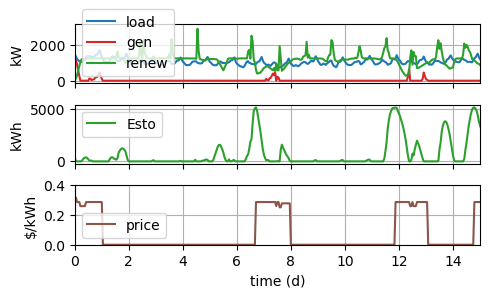

In [99]:
fig, (ax1, ax2, ax3) = plot_oper_traj(td, Pload, value.(Pgen),
    value.(pv_potential+wind_potential),
    value.(Esto),
    dual.(balance)
)
ax1.set_xlim(0, 15); # winter, high wind
ax3.set_ylim(0, 0.4); # zoom on shadow price

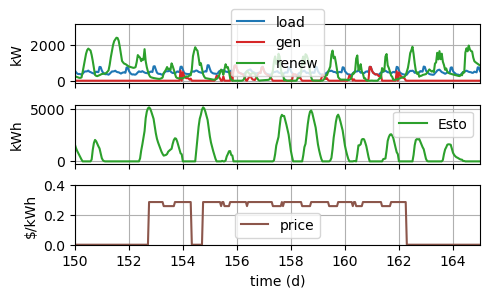

In [100]:
fig, (ax1, ax2, ax3) = plot_oper_traj(td, Pload, value.(Pgen),
    value.(pv_potential+wind_potential),
    value.(Esto),
    dual.(balance)
)
ax1.set_xlim(150, 165); # summer, low wind
ax3.set_ylim(0, 0.4); # zoom on shadow price

## Wrapping the optimization in functions

## Timing analysis

TO BE DONE

effect on optimization time of: 
- ndays
- solver (HiGHS, Clp, Gurobi)